# Normalization and batch correction

## Settings

#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

In [54]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Stomach_95'

In [55]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method='total'  # can be 'tfidf' or 'total'
# remove_pc1: if True, the first PC is removed from TFIDF-LSI normalization before calculating neighbors, 
# since first component correlates with number of features
remove_pc1 = True
log_normalize=True

# Options for highly variable genes
min_score = None

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "batch"
perform_batch_correction = False
batch_methods = ["bbknn", "mnn", "harmony", "scanorama"]

# save figures
save_figs = False

## Loading packages and setup

In [56]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
import sctoolbox.plotting as pl
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [57]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [58]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 9258 × 82859
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## Find highly variable features

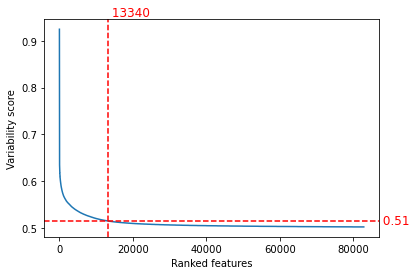

In [59]:
atac.get_variable_features(adata, min_score, show=True, inplace=True)

In [60]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

13340

In [61]:
adata = analyser.calculate_qc_metrics(adata, var_type='features')

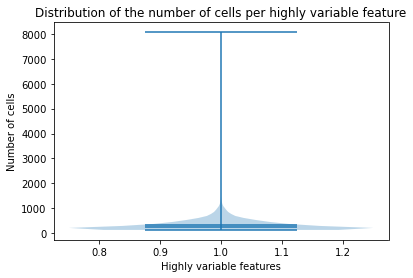

In [62]:
violin_HVF_distribution(adata)

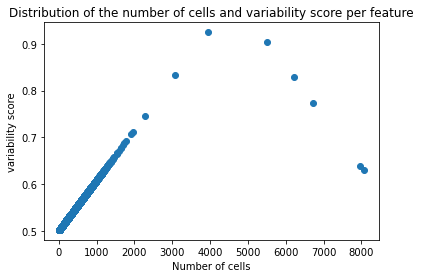

In [63]:
scatter_HVF_distribution(adata)

In [64]:
adata.var 

,peak_chr,peak_start,peak_end,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score,highly_variable
name,,,,,,,,,,,,,,
b'chr1':10001-10595,chr1,10001,10595,459,0.049579,0.048389,95.042126,459.0,6.131227,459.0,530.0,0.049579,0.549579,True
b'chr1':180710-181006,chr1,180710,181006,96,0.010369,0.010316,98.963059,96.0,4.574711,96.0,113.0,0.010369,0.510369,False
b'chr1':181437-181983,chr1,181437,181983,41,0.004429,0.004419,99.557140,41.0,3.737670,41.0,52.0,0.004429,0.504429,False
b'chr1':629113-630044,chr1,629113,630044,1961,0.211817,0.192121,78.818319,1961.0,7.581720,1961.0,2319.0,0.211817,0.711817,True
b'chr1':630234-630475,chr1,630234,630475,293,0.031648,0.031158,96.835170,293.0,5.683580,293.0,333.0,0.031648,0.531648,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'chrY':56850314-56850503,chrY,56850314,56850503,103,0.011126,0.011064,98.887449,103.0,4.644391,103.0,127.0,0.011126,0.511126,False
b'chrY':56850718-56850995,chrY,56850718,56850995,170,0.018362,0.018196,98.163750,170.0,5.141664,170.0,189.0,0.018362,0.518362,True
b'chrY':56851081-56851218,chrY,56851081,56851218,71,0.007669,0.007640,99.233096,71.0,4.276666,71.0,74.0,0.007669,0.507669,False


## Normalization

In [65]:
# Consider using parts of sctoolbox.analyser

In [66]:
if norm_method == 'tfidf':
    print('Performing TFIDF and LSI...')
    atac.tfidf(adata)
    atac.lsi(adata)
    if remove_pc1:
        adata.obsm['X_lsi'] = adata.obsm['X_lsi'][:,1:]
        adata.varm["LSI"] = adata.varm["LSI"][:,1:]
        adata.uns["lsi"]["stdev"] = adata.uns["lsi"]["stdev"][1:]
        adata.obsm['X_pca'] = adata.obsm['X_pca'][:,1:]
        adata.varm["PCs"] = adata.varm["PCs"][:,1:]
        adata.uns["pca"]["stdev"] = adata.uns["pca"]["stdev"][1:]
    print('Done')
if norm_method == 'total':
    print('Performing total and log1p normalization...')
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
    if log_normalize:
        epi.pp.log1p(adata)
    print('Done')
if not norm_method:
    adata_tfidf, adata_total = atac.atac_norm(adata, remove_pc1=remove_pc1)

Performing total and log1p normalization...
Done


In [67]:
if not norm_method:
    user_norm = input('Choose a normalization method (total or tfidf): ')
    if user_norm == 'total':
        adata = adata_total
    elif user_norm == 'tfidf':
        adata = adata_tfidf
else:
    user_norm = None
    
display(adata)

AnnData object with n_obs × n_vars = 9258 × 82859
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'highly_variable'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend', 'log1p'
    layers: 'binary', 'normalised'

## PCA

In [68]:
if norm_method == 'total':
    print('Performing PCA')
    sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=False)
    print('Done')

Performing PCA
Done


### Plot PCA

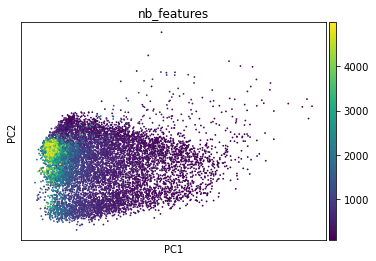

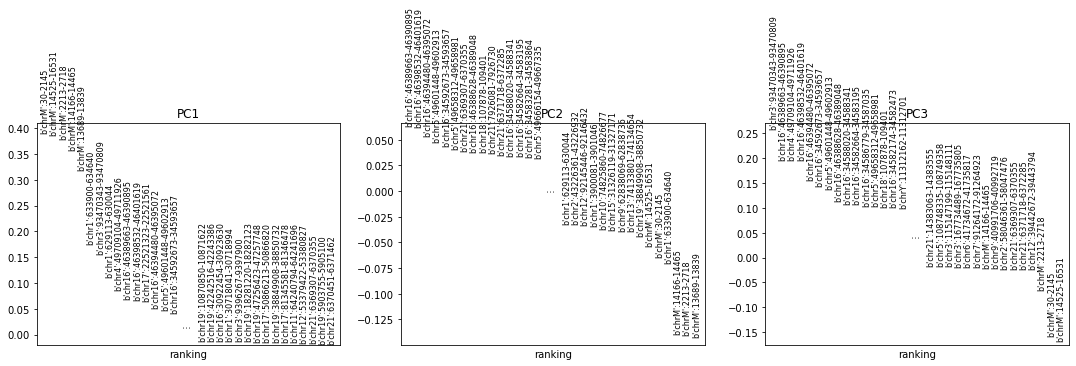

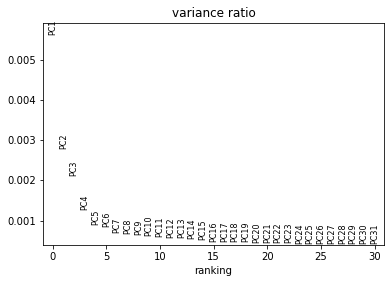

In [69]:
if norm_method == 'tfidf' or user_norm == 'tfidf':
    # Change to module
    if save_figs:
        epi.pl.pca(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca(adata, color=['nb_features'])
        
elif norm_method == 'total':
    if save_figs:
        epi.pl.pca_overview(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca_overview(adata, color=['nb_features'])

## Calc Neighbours

In [70]:
if norm_method:
    if norm_method == 'tfidf' and remove_pc1:
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, method='umap', metric='euclidean')
    else:
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')
    print('Done')

Calculating neighbors
Done


## UMAP

Computing UMAPs:   0%|          | 0/8 [00:00<?, ?it/s]

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


array([[<AxesSubplot:title={'center':'min_dist: 0.1'}, ylabel='spread: 2.0'>,
        <AxesSubplot:title={'center':'min_dist: 0.2'}>,
        <AxesSubplot:title={'center':'min_dist: 0.3'}>,
        <AxesSubplot:title={'center':'min_dist: 0.4'}>],
       [<AxesSubplot:ylabel='spread: 2.5'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

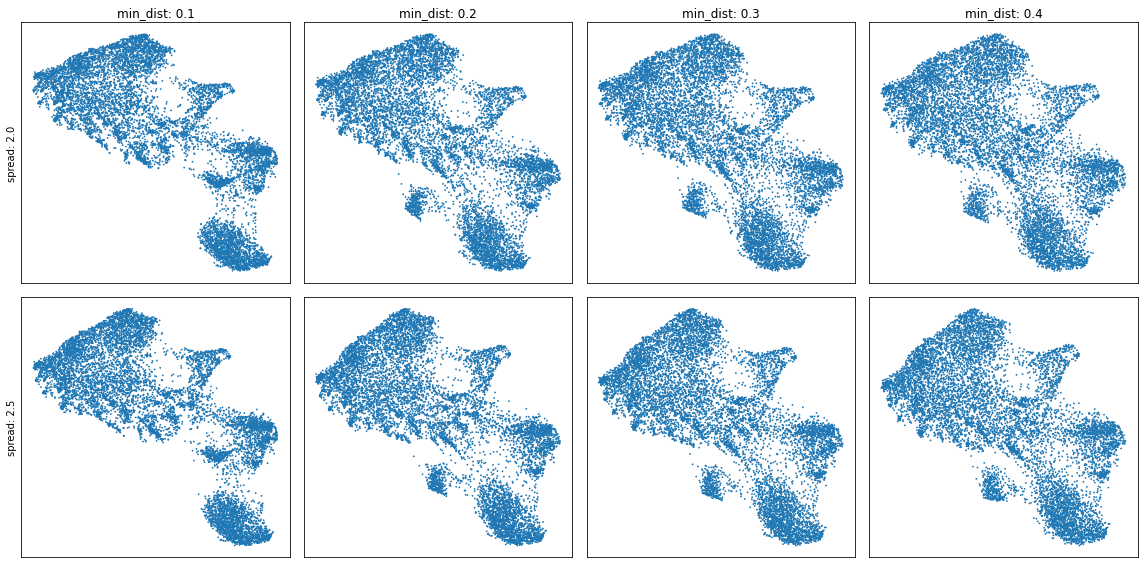

In [71]:
pl.search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol='sample', 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Batch correction

In [47]:
adata.obs['batch'] = 1

In [48]:
adata.obs['batch']

barcode
AACGAGAGCTAAACGTCCCGTT    1
AACGAGAGCTAAACTAGCCCTA    1
AACGAGAGCTAAAGCCCACGAC    1
AACGAGAGCTAAAGCGGGAGCT    1
AACGAGAGCTAAAGGATCGGCT    1
                         ..
TTTGGCGCTTTTGCATGTACGC    1
TTTGGCGCTTTTGGCTGTCTGT    1
TTTGGCGCTTTTGTCATGCGTG    1
TTTGGCGCTTTTGTCTCTTGGG    1
TTTGGCGCTTTTTGCCGGAAGG    1
Name: batch, Length: 11919, dtype: int64

In [49]:
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

In [50]:
if perform_batch_correction:
    batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

In [51]:
#Run standard umap for all adatas
analyser.wrap_umap(batch_corrections.values(), threads=threads)

NameError: name 'threads' is not defined

In [52]:
# Should preliminary clustering be performed?
do_clustering = True #True or False

In [53]:
#Perform additional clustering if it was chosen
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata)
    color_by.append("leiden")

NameError: name 'color_by' is not defined

In [ ]:
# Calculate LISI scores for batch
analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

In [ ]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
                        output=figure_path + "batch_correction_overview.pdf")

## save anndata

In [73]:
adata_output = tree.norm_correction_anndata
adata.write(filename=adata_output)